# Boosting
##### Imports

In [1]:
# import libraries
import warnings
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# import sklearn model training
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

# import visualization library
from matplotlib import pyplot as plt

%matplotlib inline

### Data Loading + Preprocessing

In [2]:
# initialize class
tp = Tadpole(debug=True)

In [3]:
# load and pre-process tadpole dataset
tp.load()
print(tp.label_dict)

loading tadpole dataset
pre-processing dataset
{0: 'AD', 1: 'CN', 2: 'MCI'}


##### Split data into Train and Test datasets

In [4]:
# train-test split
tp.split()

splitting dataset to train and test datasets


In [5]:
# import variables from class instance (notebook compatibility)
label_dict = tp.label_dict
X, y, X_train, X_test, y_train, y_test = tp.X, tp.y, tp.X_train, tp.X_test, tp.y_train, tp.y_test

### Helper Functions

In [6]:
# Source: https://stackoverflow.com/questions/55632010/using-scikit-learns-mlpclassifier-in-adaboostclassifier
class CustomMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

In [7]:
def boosting_clf(clf):
    if (isinstance(clf,SVC)):
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, 
                                  algorithm = 'SAMME', learning_rate = 0.1)
    else:
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, learning_rate = 0.1)

In [8]:
def accuracy(clf, X, y):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    print('Balanced accuracy score: ', BCA)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovo", average="macro")
    print('Overall mAUC: ', mAUC)

In [9]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
       for j in range(3):
           ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [10]:
def report_accuracy(clf):
    print('Train metrics:')
    accuracy(clf, X_train, y_train)
    print('\n\nTest metrics:')
    accuracy(clf, X_test, y_test)
    showConfusionMatrix(clf, X_test, y_test)

In [11]:
def evaluate(Classifier, **kwargs):
    print('+ Base learner')
    clf = Classifier(**kwargs).fit(X_train, y_train)
    report_accuracy(clf)
    print('+ Ensemble')
    boost_clf = boosting_clf(Classifier(**kwargs)).fit(X_train, y_train)
    report_accuracy(boost_clf)

In [12]:
def main():
    baselearners = [DecisionTreeClassifier, 
                    SVC, 
                    CustomMLPClassifier,
                    LogisticRegression]
    
    for learner in baselearners:
        print(learner)
        evaluate(learner)
        print()

### Model Training

##### Decision Tree

+ Base learner
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.8355401945724527
Overall mAUC:  0.8766551459293396


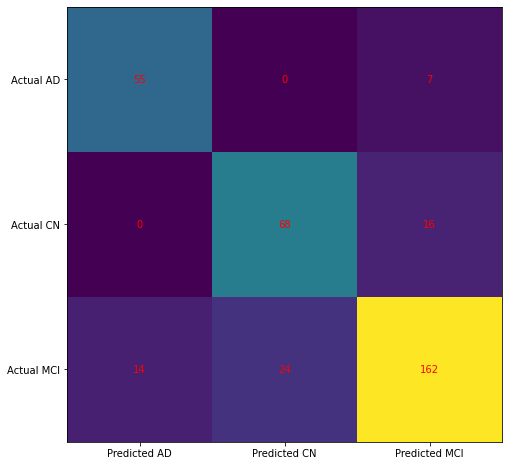

+ Ensemble
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.8384971838197645
Overall mAUC:  0.8788728878648233


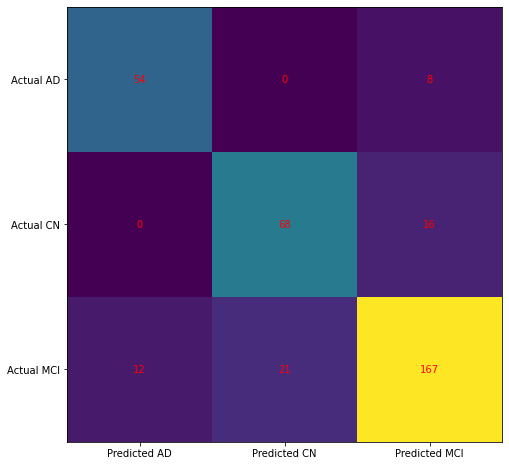

In [13]:
evaluate(DecisionTreeClassifier)

##### Logistic Regression Analysis (LRA)

+ Base learner
Train metrics:
Balanced accuracy score:  0.8097880755915684
Overall mAUC:  0.9601234307359686


Test metrics:
Balanced accuracy score:  0.7994905273937531
Overall mAUC:  0.9592767537122375


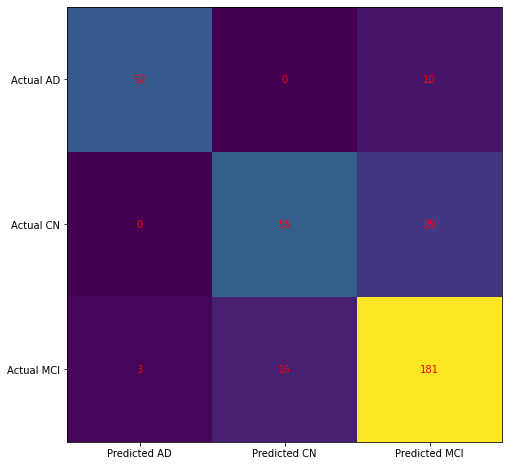

+ Ensemble
Train metrics:
Balanced accuracy score:  0.354916067146283
Overall mAUC:  0.8352084386481654


Test metrics:
Balanced accuracy score:  0.3602150537634408
Overall mAUC:  0.8370471710189452


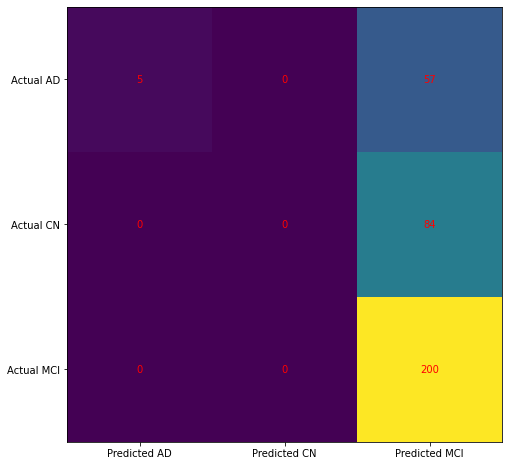

In [14]:
evaluate(LogisticRegression)

##### Artifical Neural Network (ANN)

+ Base learner
Train metrics:
Balanced accuracy score:  0.8744377502578388
Overall mAUC:  0.9732087200330369


Test metrics:
Balanced accuracy score:  0.8756400409626216
Overall mAUC:  0.9690767409114184


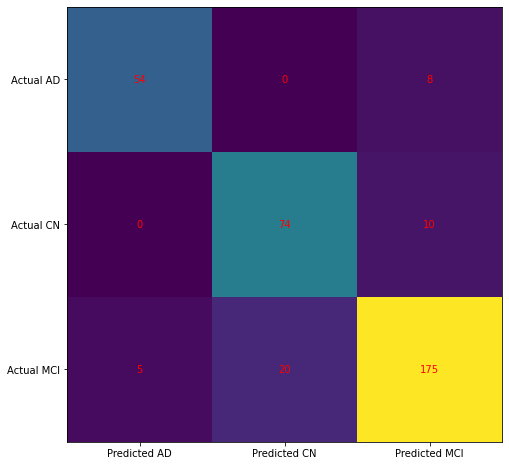

+ Ensemble
Train metrics:
Balanced accuracy score:  0.8731848537347883
Overall mAUC:  0.9566328256953934


Test metrics:
Balanced accuracy score:  0.8577393753200205
Overall mAUC:  0.942279505888377


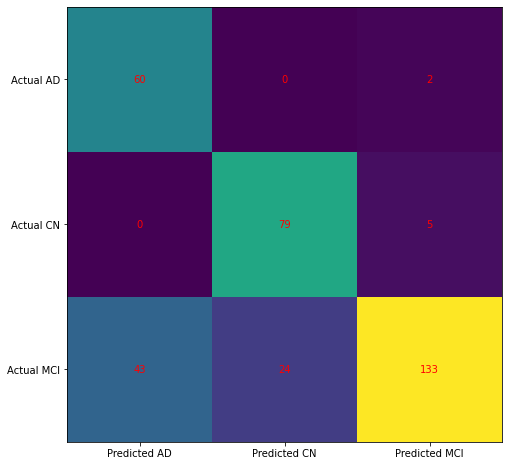

In [15]:
evaluate(CustomMLPClassifier)

##### SVM

+ Base learner
Train metrics:
Balanced accuracy score:  0.8802071684432008
Overall mAUC:  0.9743254159950473


Test metrics:
Balanced accuracy score:  0.8583384536610343
Overall mAUC:  0.9651337685611882


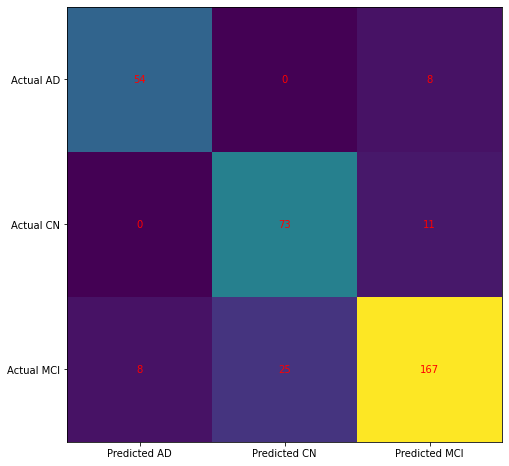

+ Ensemble
Train metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.5


Test metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.5


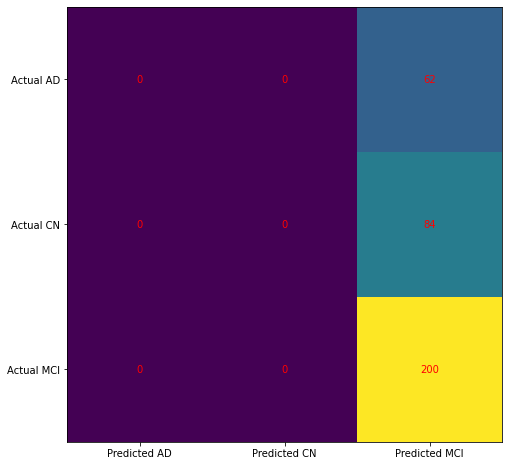

In [16]:
evaluate(SVC, probability = True)

##### All base learners at once

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
+ Base learner
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.8235176651305683
Overall mAUC:  0.8676382488479263


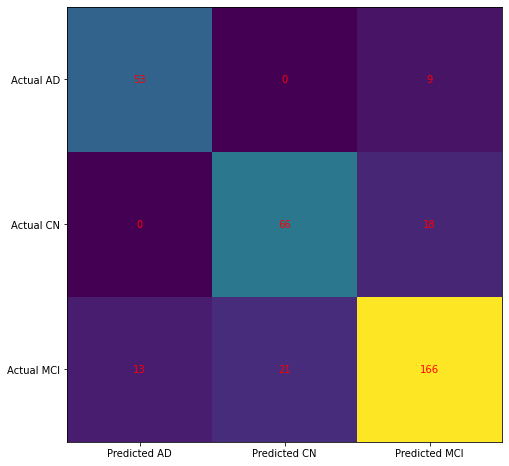

+ Ensemble
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.8384971838197645
Overall mAUC:  0.8788728878648233


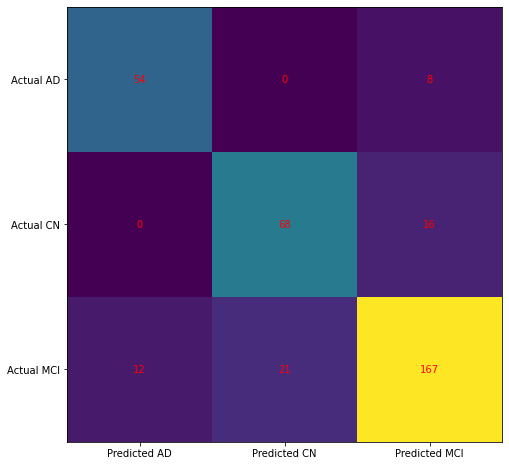


<class 'sklearn.svm._classes.SVC'>
+ Base learner
Train metrics:


AttributeError: predict_proba is not available when  probability=False

In [17]:
main()

### Experiment
Repeat 100 times